#Medical Image Analysis to predict Pneumonia

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torchinfo

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from PIL import Image
import random
from pathlib import Path
import torch
from torch import nn
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchinfo import summary
from timeit import default_timer as timer

In [ ]:
device = 'cuda' if torch.cuda.is_available else 'cpu'
device

'cuda'

In [ ]:
image_path = Path('/content/drive/MyDrive/Chest Xray')
image_path

PosixPath('/content/drive/MyDrive/Chest Xray')

In [ ]:
train_dir = image_path / 'train_data'
test_dir = image_path / 'test_data'
train_dir, test_dir

(PosixPath('/content/drive/MyDrive/Chest Xray/train_data'),
 PosixPath('/content/drive/MyDrive/Chest Xray/test_data'))

In [ ]:
def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

walk_through_dir(image_path)

There are 2 directories and 0 images in '/content/drive/MyDrive/Chest Xray'.
There are 2 directories and 0 images in '/content/drive/MyDrive/Chest Xray/train_data'.
There are 0 directories and 500 images in '/content/drive/MyDrive/Chest Xray/train_data/normal_'.
There are 0 directories and 500 images in '/content/drive/MyDrive/Chest Xray/train_data/pneumonia_'.
There are 2 directories and 0 images in '/content/drive/MyDrive/Chest Xray/test_data'.
There are 0 directories and 150 images in '/content/drive/MyDrive/Chest Xray/test_data/pneumonia_'.
There are 0 directories and 150 images in '/content/drive/MyDrive/Chest Xray/test_data/normal_'.


Random image path: /content/drive/MyDrive/Chest Xray/train_data/normal_/NORMAL-2597757-0001.jpeg
Image class: normal_
Image height: 1074
Image width: 1636


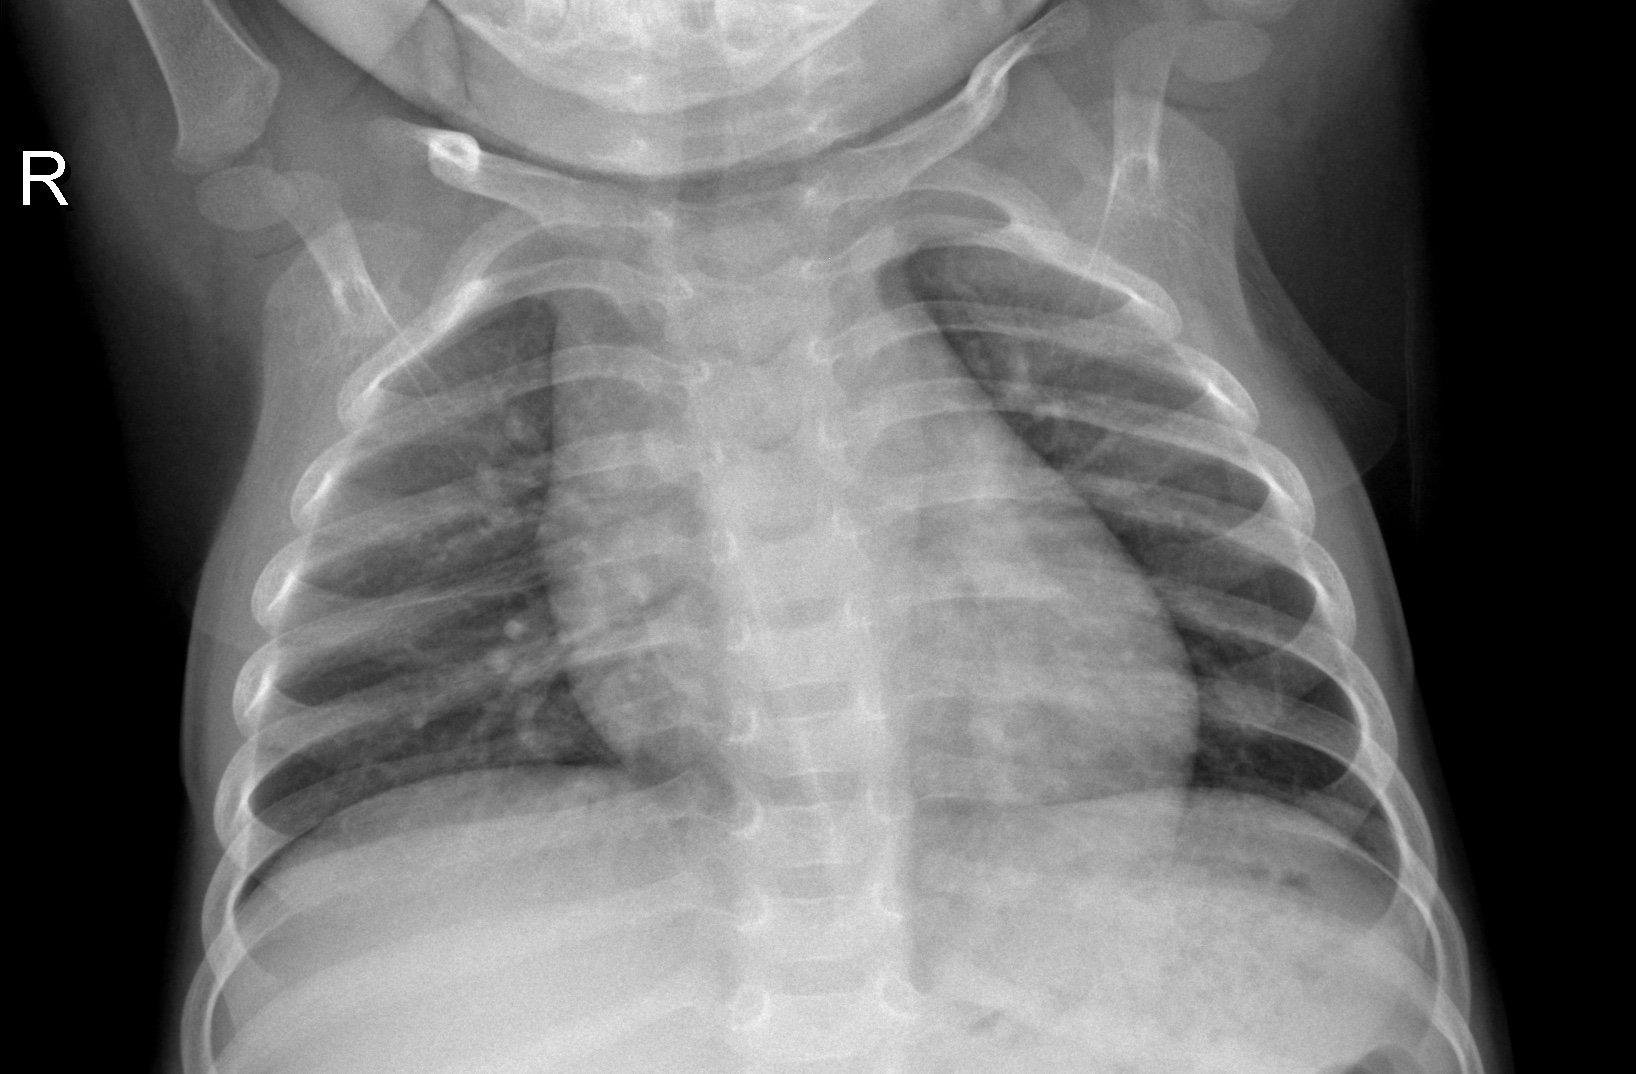

In [ ]:
random.seed(42)

# Picking a random image path
image_path_list = list(image_path.glob("*/*/*.jpeg"))
random_image_path = random.choice(image_path_list)

# Get image class
image_class = random_image_path.parent.stem

# Open Image
img = Image.open(random_image_path) # Shape: [height, width, colour channels]

print(f'Random image path: {random_image_path}')
print(f"Image class: {image_class}")
print(f'Image height: {img.height}')
print(f'Image width: {img.width}')
img

In [ ]:
np.asarray(img).shape # [height, width, colour channels]

(1074, 1636)

##Displaying a few comparisons between Normal and Pneumonia affected Lung

In [ ]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(path = folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

In [ ]:
normal_lung_train = '/content/drive/MyDrive/Chest Xray/train_data/normal_'
pneumonia_lung_train = '/content/drive/MyDrive/Chest Xray/train_data/pneumonia_'
normal_lung_test = '/content/drive/MyDrive/Chest Xray/test_data/normal_'
pneumonia_lung_test = '/content/drive/MyDrive/Chest Xray/test_data/pneumonia_'

In [ ]:
normal_train_images = load_images_from_folder(normal_lung_train)
pneumonia_train_images = load_images_from_folder(pneumonia_lung_train)
normal_test_images = load_images_from_folder(normal_lung_test)
pneumonia_test_images = load_images_from_folder(pneumonia_lung_test)

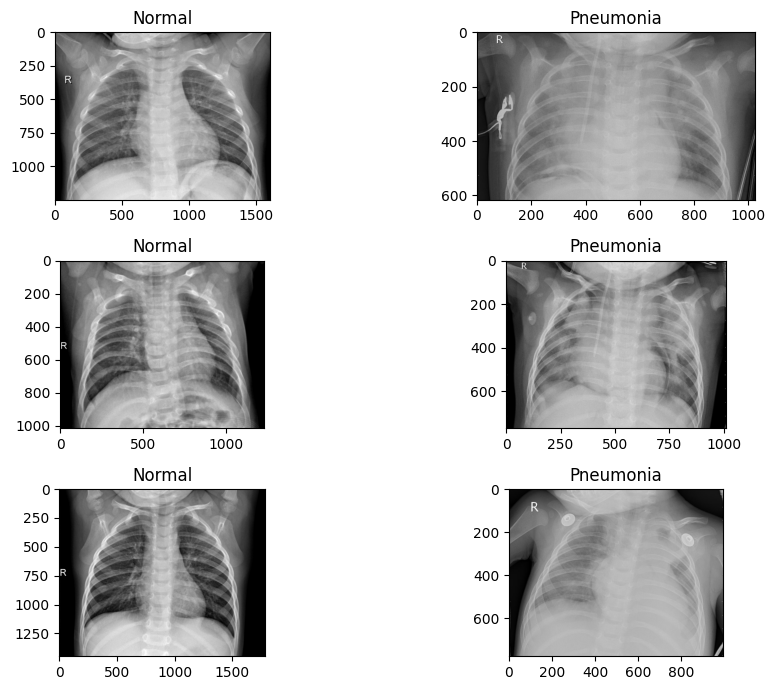

In [ ]:
plt.figure(figsize=(10,7))
plt.subplot(321)
plt.imshow(normal_train_images[0])
plt.title('Normal')
plt.subplot(322)
plt.imshow(pneumonia_train_images[0])
plt.title('Pneumonia')
plt.subplot(323)
plt.imshow(normal_train_images[1])
plt.title('Normal')
plt.subplot(324)
plt.imshow(pneumonia_train_images[1])
plt.title('Pneumonia')
plt.subplot(325)
plt.imshow(normal_train_images[2])
plt.title('Normal')
plt.subplot(326)
plt.imshow(pneumonia_train_images[2])
plt.title('Pneumonia')
plt.tight_layout()
plt.show()

In [ ]:
print("Infernce:\nFrom the above X-ray images, we learn that a lung affected by Pneumonia is shaded, the more shaded the lung is, the more the Pneumonia has been spread\nAlso, a healthy lung does not have any shaded region")

Infernce:
From the above X-ray images, we learn that a lung affected by Pneumonia is shaded, the more shaded the lung is, the more the Pneumonia has been spread
Also, a healthy lung does not have any shaded region


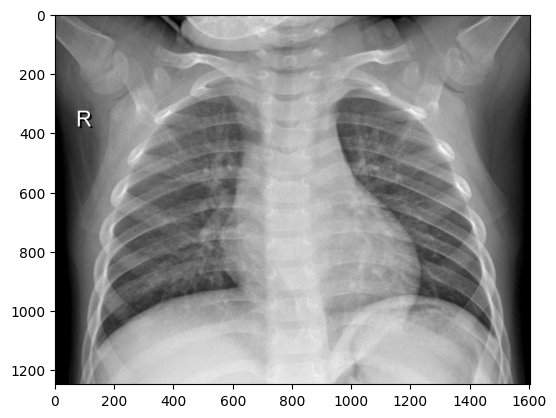

In [ ]:
plt.imshow(normal_train_images[0])

##Transforming our data into tensors
PyTorch requires our image data to be Tensors

We will be converting our dataset into dataloaders

###Transforming our data with torchvision.transforms

In [ ]:
# Write a transform for image
data_transform = transforms.Compose([
    # Resize our images because there exists non-uniformity in sizes of images in the data
    transforms.Resize(size=(128,128)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.3),
    # Adding Gaussian Blur to the images
    transforms.GaussianBlur((3,3), 0.1),
    # Inverting the images randomly
    transforms.RandomInvert(p=0.2),
    # Adjusting the sharpness of images randomly
    transforms.RandomAdjustSharpness(sharpness_factor = 1.2, p=0.3),
    # Adjusting the contrast of images randomly
    transforms.RandomAutocontrast(p=0.4),
    # Turn the image into a tensor
    transforms.ToTensor() # Normalizes the image
])

In [ ]:
data_transform(img) # Image having pixel values in the range [0,1]

tensor([[[0.0314, 0.0863, 0.1373,  ..., 0.0000, 0.0000, 0.0000],
         [0.0235, 0.0745, 0.1294,  ..., 0.0000, 0.0000, 0.0000],
         [0.0118, 0.0588, 0.1137,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]])

In [ ]:
print(f'Original Image Shape: {np.asarray(img).shape}') # [height, width, colour channel]
print(f'Transformed Image Shape: {data_transform(img).shape }') # [colour channel, height, width]

Original Image Shape: (1074, 1636)
Transformed Image Shape: torch.Size([1, 128, 128])


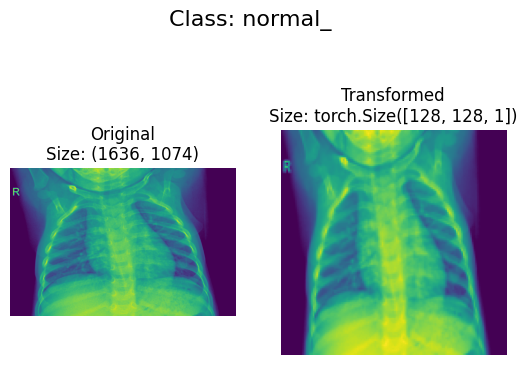

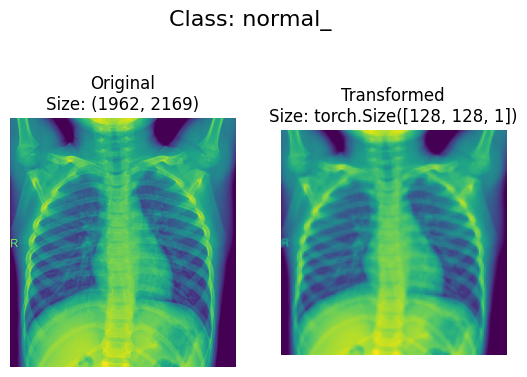

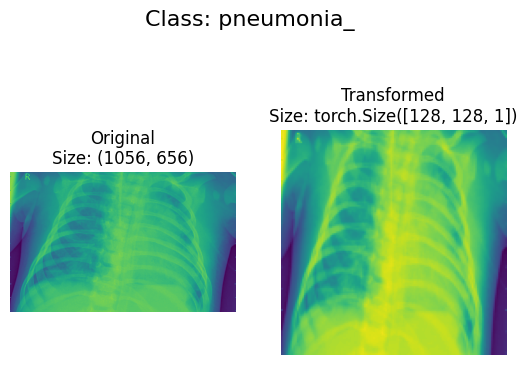

In [ ]:
# Transformed images thus make our images ready to train and put in a model
# Transforming more images
def plot_transformed_images(image_paths, transform, n=3, seed=None):
  if seed:
    random.seed(seed)

  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f'Original\nSize: {f.size}')
      ax[0].axis(False)

      # Transform and plot target image
      transformed_image = transform(f).permute(1, 2, 0) # [C, H, W] -> [H, W, C]
      ax[1].imshow(transformed_image)
      ax[1].set_title(f'Transformed\nSize: {transformed_image.shape}')
      ax[1].axis('off')

      fig.suptitle(f'Class: {image_path.parent.stem}', fontsize=16)

plot_transformed_images(
    image_paths = image_path_list,
    transform = data_transform,
    n=3,
    seed=42
)

In [ ]:
print("Inference:\nThe images which were initially of non-uniform sizes, have been resized to a uniform size of [128,128]\nAlso, the images have been augmented with contrasting, flipping, blurring, inverting and sharpening techniques\nHowever, transforming the images to a smaller resolution may lead to loss of information\nIn order to overcome this loss of information the suggested methods would possibly be:\n\t1. Use image pyramids: Passing different resolutions of the same image so that the model can work on both low and high resolutions.\n\t2. Data Augmentation: Augmenting the data will provide the model with variations of the same image, thus mitigating some loss of information.\n\t3. Transfer learning: If possible, use pre-trained models that were trained on larger datasets and fine-tune them for your specific task.\n\t   Transfer learning can help alleviate the loss of information by leveraging knowledge learned from extensive data.")

Inference:
The images which were initially of non-uniform sizes, have been resized to a uniform size of [128,128]
Also, the images have been augmented with contrasting, flipping, blurring, inverting and sharpening techniques
However, transforming the images to a smaller resolution may lead to loss of information
In order to overcome this loss of information the suggested methods would possibly be:
	1. Use image pyramids: Passing different resolutions of the same image so that the model can work on both low and high resolutions.
	2. Data Augmentation: Augmenting the data will provide the model with variations of the same image, thus mitigating some loss of information.
	3. Transfer learning: If possible, use pre-trained models that were trained on larger datasets and fine-tune them for your specific task.
	   Transfer learning can help alleviate the loss of information by leveraging knowledge learned from extensive data.


##Loading image data using ImageFolder

In [ ]:
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform, # for features
                                  target_transform = None) # for labels

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 1000
     Root location: /content/drive/MyDrive/Chest Xray/train_data
     StandardTransform
 Transform: Compose(
                Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.3)
                GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 0.1))
                RandomInvert(p=0.2)
                RandomAdjustSharpness(sharpness_factor=1.2,p=0.3)
                RandomAutocontrast(p=0.4)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 300
     Root location: /content/drive/MyDrive/Chest Xray/test_data
     StandardTransform
 Transform: Compose(
                Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.3)
                GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 0.1))
                RandomInvert(p=0.2)
                RandomAdjustSharpness(sharpn

In [ ]:
class_names = train_data.classes
class_names

['normal_', 'pneumonia_']

In [ ]:
class_dict = train_data.class_to_idx
class_dict

{'normal_': 0, 'pneumonia_': 1}

In [ ]:
len(train_data), len(test_data)

(1000, 300)

In [ ]:
train_data.samples[0]

('/content/drive/MyDrive/Chest Xray/train_data/normal_/NORMAL-1003233-0001.jpeg',
 0)

In [ ]:
img, label = train_data[0][0], train_data[0][1]
print(f'Image Tensor:\n{img}')
print(f'Image Shape: {img.shape}')
print(f'Image datatype: {img.dtype}')
print(f'Image label: {label}')
print(f'Image label datatype: {type(label)}') # Succesfully turned our images to numeric format

Image Tensor:
tensor([[[0.4157, 0.4196, 0.4078,  ..., 0.5843, 0.6627, 0.6157],
         [0.4118, 0.4157, 0.4078,  ..., 0.6510, 0.6471, 0.4510],
         [0.4118, 0.4157, 0.4157,  ..., 0.6588, 0.4706, 0.4235],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.4157, 0.4196, 0.4078,  ..., 0.5843, 0.6627, 0.6157],
         [0.4118, 0.4157, 0.4078,  ..., 0.6510, 0.6471, 0.4510],
         [0.4118, 0.4157, 0.4157,  ..., 0.6588, 0.4706, 0.4235],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.4157, 0.4196, 0.4078,  ..., 0.5843, 0.6627, 0.6157],
         [0.4118, 0.4157, 0.4078,  ..., 0.6510, 0.6471, 0.4510],
         [0.4118, 0.4157, 0.4157,  ..., 0.65

Original shape: torch.Size([3, 128, 128]) -> [C, H, W]
Image permute: torch.Size([128, 128, 3]) -> [H,W,C]




<function matplotlib.pyplot.show(close=None, block=None)>

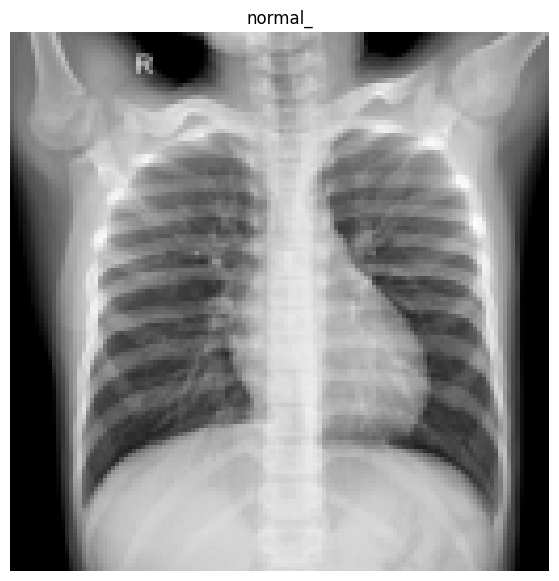

In [ ]:
img_permute = img.permute(1,2,0)
print(f'Original shape: {img.shape} -> [C, H, W]')
print(f'Image permute: {img_permute.shape} -> [H,W,C]')
print('\n')

# Plot the image
plt.figure(figsize=(10,7))
plt.imshow(img_permute)
plt.axis('off')
plt.title(class_names[label])
plt.show

##Turning our dataset into a DataLoader
This helps us turn our Dataset into iterables(batches)

In [ ]:
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=32,
                              num_workers=1,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=32,
                             num_workers=1,
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x79bf02b09ff0>,
 <torch.utils.data.dataloader.DataLoader at 0x79bf02cb9240>)

In [ ]:
len(train_dataloader), len(test_dataloader) # 32 batches for train, 10 batches for test

(32, 10)

In [ ]:
img, label = next(iter(train_dataloader))

print(f'Image shape: {img.shape} -> [batch_size, C, H, W]')
print(f'Label Shape: {label.shape}')

Image shape: torch.Size([32, 3, 128, 128]) -> [batch_size, C, H, W]
Label Shape: torch.Size([32])


##Building our Model: model_0

In [ ]:
# Starting to experiment with simple transforms and gradually building up to better transforms
simple_transform = data_transform

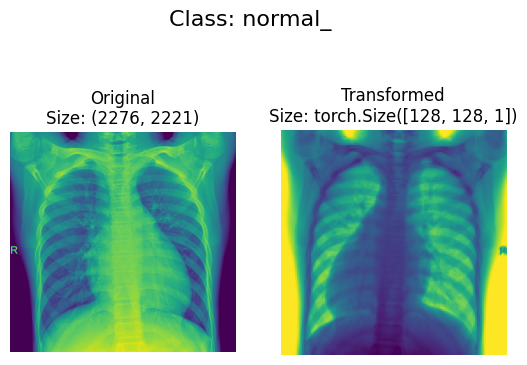

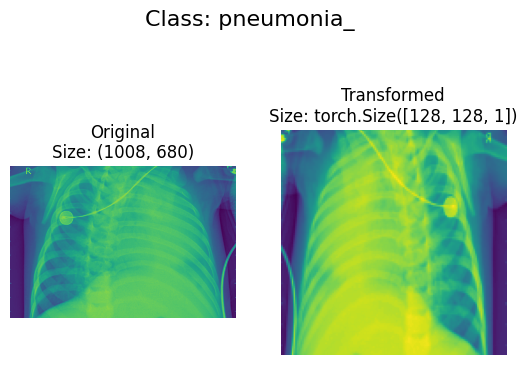

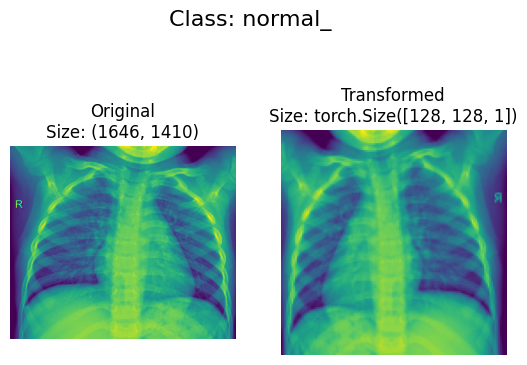

In [ ]:
# Analysing transformed train data
plot_transformed_images(
    image_paths = image_path_list,
    transform = simple_transform,
    n = 3,
    seed = 20
)

In [ ]:
print("Inference: The images have thus been transformed, resized with an addition of sharpness, blurring and horizontal flips each having certain probabilities\nThis adds different type of images for our model to learn so that it does not fail to predict incorrectly in any case")

Inference: The images have thus been transformed, resized with an addition of sharpness, blurring and horizontal flips each having certain probabilities
This adds different type of images for our model to learn so that it does not fail to predict incorrectly in any case


In [ ]:
# Load and transform data
train_data_simple = datasets.ImageFolder(
    root=train_dir,
    transform=simple_transform,
    target_transform=None
)

test_data_simple = datasets.ImageFolder(
    root=test_dir,
    transform=simple_transform
)

# Batch size and number of CPU's
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

# Create DataLoaders
train_dataloader_simple = DataLoader(
    dataset = train_data_simple,
    batch_size = BATCH_SIZE,
    shuffle = True,
    num_workers = NUM_WORKERS
)

test_dataloader_simple = DataLoader(
    dataset = test_data_simple,
    batch_size = BATCH_SIZE,
    shuffle = False,
    num_workers = NUM_WORKERS
)

In [ ]:
class CNNv0(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2) # default stride value is same as kernel_size
    )

    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*29*29,
                  out_features=output_shape)
    )

    self.dropout = nn.Dropout(p=0.3)

  def forward(self, x):
    x = self.conv_block_1(x)
    x = self.conv_block_2(x)
    x = self.classifier(x)
    return x

In [ ]:
torch.manual_seed(42)
model_0 = CNNv0(input_shape=3, hidden_units=10, output_shape=len(class_names)).to(device)

model_0

CNNv0(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=8410, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.3, inplace=False)
)

In [ ]:
# Try out a forward pass on a single image
image_batch, label_batch = next(iter(train_dataloader_simple))
model_0(image_batch.to(device))

tensor([[ 5.1927e-03, -3.9144e-02],
        [ 3.8241e-03, -4.1532e-02],
        [ 3.3156e-03, -3.9792e-02],
        [ 6.2798e-03, -3.8714e-02],
        [ 3.2496e-03, -4.0201e-02],
        [ 5.5538e-03, -4.0117e-02],
        [ 5.0425e-03, -4.0076e-02],
        [ 2.5270e-03, -3.9229e-02],
        [ 5.6246e-03, -3.8013e-02],
        [ 1.8819e-03, -3.2500e-02],
        [ 5.7570e-03, -3.7939e-02],
        [ 5.1699e-03, -3.8468e-02],
        [ 4.4693e-03, -3.9623e-02],
        [-7.5218e-06, -3.6635e-02],
        [ 7.3021e-04, -3.6379e-02],
        [ 3.9775e-03, -3.8940e-02],
        [ 4.8037e-04, -3.3825e-02],
        [ 3.2652e-03, -3.8151e-02],
        [ 6.1039e-03, -4.0429e-02],
        [ 1.4309e-03, -3.2978e-02],
        [ 1.5108e-03, -3.6718e-02],
        [ 1.7218e-03, -3.6743e-02],
        [ 5.1985e-03, -4.1922e-02],
        [ 3.4735e-03, -4.1969e-02],
        [ 5.8140e-03, -3.8753e-02],
        [ 4.3095e-03, -3.7256e-02],
        [ 4.6950e-03, -4.1860e-02],
        [ 2.8226e-03, -4.068

In [ ]:
summary(model_0, input_size=[1,3,128,128])

Layer (type:depth-idx)                   Output Shape              Param #
CNNv0                                    [1, 2]                    --
├─Sequential: 1-1                        [1, 10, 62, 62]           --
│    └─Conv2d: 2-1                       [1, 10, 126, 126]         280
│    └─ReLU: 2-2                         [1, 10, 126, 126]         --
│    └─Conv2d: 2-3                       [1, 10, 124, 124]         910
│    └─ReLU: 2-4                         [1, 10, 124, 124]         --
│    └─MaxPool2d: 2-5                    [1, 10, 62, 62]           --
├─Sequential: 1-2                        [1, 10, 29, 29]           --
│    └─Conv2d: 2-6                       [1, 10, 60, 60]           910
│    └─ReLU: 2-7                         [1, 10, 60, 60]           --
│    └─Conv2d: 2-8                       [1, 10, 58, 58]           910
│    └─ReLU: 2-9                         [1, 10, 58, 58]           --
│    └─MaxPool2d: 2-10                   [1, 10, 29, 29]           --
├─Sequentia

###Create train and test loop functions


In [ ]:
# Create the train step
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device = device):
  # Set the model to training mode
  model.train()

  # Setup the training loss and accuracy
  train_loss, train_acc = 0, 0

  # Loop through the dataloader
  for batch, (X,y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    # 1. Forward pass
    y_pred = model(X) # outputs model logits

    # Calculate the loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Backpropagation
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # 6. Calculate accuracy metric
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1) # logits -> prediction probabilities -> prediction labels
    train_acc += (y_pred_class == y).sum().item() / len(y_pred)

  # Adjust the metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)

  return train_loss, train_acc

In [ ]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device = device):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

###Combine train step and test step

In [ ]:
# 1. Create a train function that takes various model parameters
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          epochs: int,
          device = device):
  # 2. Create empty results dictionary
  results = {
      "train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": [],
  }

  # 3. Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(
        model = model,
        dataloader = train_dataloader,
        loss_fn = loss_fn,
        optimizer = optimizer,
        device = device
    )

    test_loss, test_acc = test_step(
        model = model,
        dataloader = test_dataloader,
        loss_fn = loss_fn,
        device = device
    )

    # 4. Print out the progress
    print(f'Epoch: {epoch} | Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc*100:.2f}% | Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc*100:.2f}%')

    # 5. Update results dictionary
    results['train_loss'].append(train_loss)
    results['test_loss'].append(test_loss)
    results['train_acc'].append(train_acc)
    results['test_acc'].append(test_acc)

  # 6. Return the results at the end of the epochs
  return results

###Training and evaluating our model

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 25

model_0 = CNNv0(input_shape=3,
                hidden_units=10,
                output_shape=len(train_data.classes)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr = 0.0001)

# Start the timer
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        loss_fn=loss_fn,
                        optimizer=optimizer,
                        epochs=NUM_EPOCHS)

end_time = timer()
print(f'Total training time: {end_time - start_time:.3f} seconds')

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 0 | Train Loss: 0.6945 | Train Accuracy: 49.90% | Test Loss: 0.6932 | Test Accuracy: 46.88%
Epoch: 1 | Train Loss: 0.6934 | Train Accuracy: 48.24% | Test Loss: 0.6930 | Test Accuracy: 46.88%
Epoch: 2 | Train Loss: 0.6917 | Train Accuracy: 49.90% | Test Loss: 0.6915 | Test Accuracy: 46.88%
Epoch: 3 | Train Loss: 0.6864 | Train Accuracy: 61.72% | Test Loss: 0.6845 | Test Accuracy: 72.08%
Epoch: 4 | Train Loss: 0.6784 | Train Accuracy: 67.29% | Test Loss: 0.6753 | Test Accuracy: 57.92%
Epoch: 5 | Train Loss: 0.6555 | Train Accuracy: 65.04% | Test Loss: 0.6483 | Test Accuracy: 73.12%
Epoch: 6 | Train Loss: 0.6296 | Train Accuracy: 70.31% | Test Loss: 0.6251 | Test Accuracy: 67.92%
Epoch: 7 | Train Loss: 0.5916 | Train Accuracy: 72.46% | Test Loss: 0.5769 | Test Accuracy: 76.77%
Epoch: 8 | Train Loss: 0.5682 | Train Accuracy: 74.02% | Test Loss: 0.5548 | Test Accuracy: 74.48%
Epoch: 9 | Train Loss: 0.5383 | Train Accuracy: 75.59% | Test Loss: 0.5548 | Test Accuracy: 75.62%
Epoch: 10 

In [ ]:
print("Inference:\nAfter running for 25 epochs, we observe an overfitting in the model as the difference between percentages of training and testing accuracy is approximately 10%\nThis can lead to problems as this is a medical imaging data, lesser accuracy and overfitting can cause incorrect predictions and thus can cause health risks to the patients\nIn order to overcome this Overfitting, we could: \n\t1. Further increase the number of epochs so that model has more time to learn\n\t2. Add dropout layers in our Neural Network which would turn off a number of neurons and only the required neurons would be activated for learning the patterns\n\t3. Adding batch normalization can lead to better generalization and the ability to handle a wide range of inputs and variations in data distribution.")

Inference:
After running for 25 epochs, we observe an overfitting in the model as the difference between percentages of training and testing accuracy is approximately 10%
This can lead to problems as this is a medical imaging data, lesser accuracy and overfitting can cause incorrect predictions and thus can cause health risks to the patients
In order to overcome this Overfitting, we could: 
	1. Further increase the number of epochs so that model has more time to learn
	2. Add dropout layers in our Neural Network which would turn off a number of neurons and only the required neurons would be activated for learning the patterns
	3. Adding batch normalization can lead to better generalization and the ability to handle a wide range of inputs and variations in data distribution.


In [ ]:
train_dataloader_simple

In [ ]:
def plot_loss_curves(results):
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

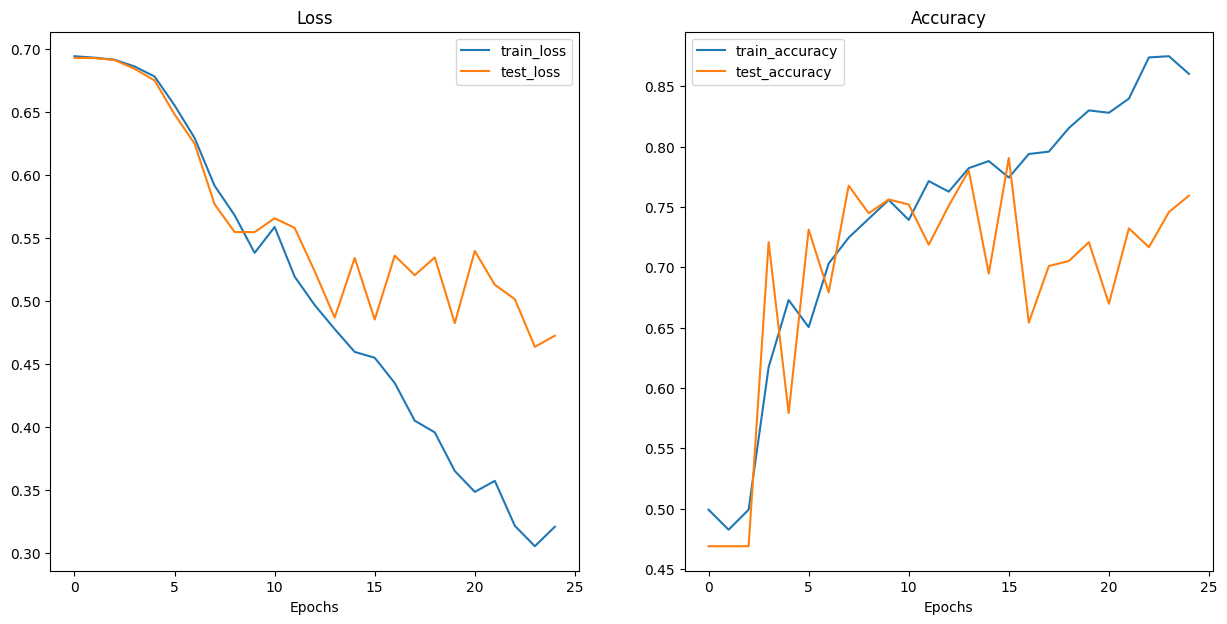

In [ ]:
plot_loss_curves(model_0_results)

In [ ]:
print("Inference:\nWe see the loss getting decreased and accuracy getting increased but there is an issue here:\nThe Testing Loss and Accuracy should not cross the Training Loss and Accuracy curves respectively\nThis further helps us draw an inference that there is an Overfitting in the model")

Inference:
We see the loss getting decreased and accuracy getting increased but there is an issue here:
The Testing Loss and Accuracy should not cross the Training Loss and Accuracy curves respectively
This further helps us draw an inference that there is an Overfitting in the model


Single image shape: torch.Size([1, 3, 128, 128])

Output logits:
tensor([[ 0.1515, -0.1339]], device='cuda:0')

Output prediction probabilities:
tensor([[0.5709, 0.4291]], device='cuda:0')

Output prediction label:
tensor([0], device='cuda:0')

Actual label:
0


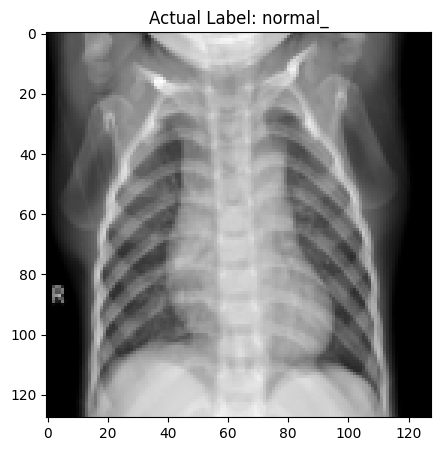

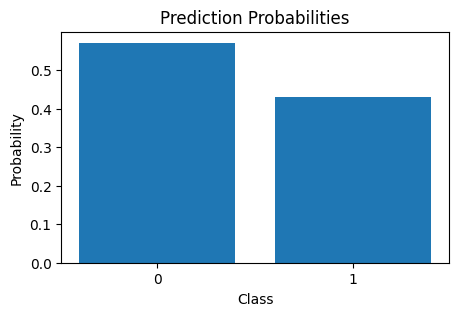

In [ ]:
# 1. Get a batch of images and labels from the DataLoader
img_batch, label_batch = next(iter(test_dataloader_simple))

# 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
img_single, label_single = img_batch[2].unsqueeze(dim=0), label_batch[2]
print(f"Single image shape: {img_single.shape}\n")

# 3. Perform a forward pass on a single image
model_0.eval()
with torch.inference_mode():
    pred = model_0(img_single.to(device))

# 4. Print out the predictions and convert model logits -> pred probs -> pred label
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

# 5. Visualize the image and predictions
image = img_single.squeeze(0).permute(1, 2, 0).numpy()  # Convert the image tensor to a NumPy array

# Plot the image
plt.figure(figsize=(5, 5))
plt.imshow(image, cmap='gray')
plt.title(f"Actual Label: {class_names[label_single]}")

# Create a bar chart for prediction probabilities
pred_probs = torch.softmax(pred, dim=1).squeeze(0).cpu().numpy()
plt.figure(figsize=(5, 3))
plt.bar(range(len(pred_probs)), pred_probs)
plt.xticks(range(len(pred_probs)))
plt.xlabel("Class")
plt.ylabel("Probability")
plt.title("Prediction Probabilities")

# Show the plot
plt.show()


In [ ]:
print("Inference:\nThe histogram for the Prediction Probabilities tell us the probability of our prediction being\nNormal Lung when the actual label is also of a Normal Lung\nHence the model predictions were accurate")

Inference:
The histogram for the Prediction Probabilities tell us the probability of our prediction being
Normal Lung when the actual label is also of a Normal Lung
Hence the model predictions were accurate


Single image shape: torch.Size([1, 3, 128, 128])

Output logits:
tensor([[-0.0877, -0.0616]], device='cuda:0')

Output prediction probabilities:
tensor([[0.4935, 0.5065]], device='cuda:0')

Output prediction label:
tensor([1], device='cuda:0')

Actual label:
0


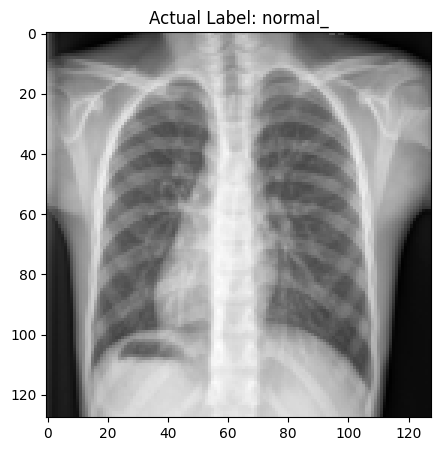

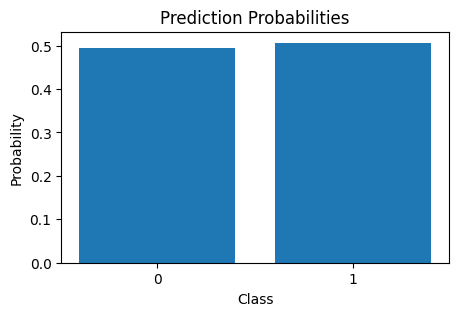

In [ ]:
# 1. Get a batch of images and labels from the DataLoader
img_batch, label_batch = next(iter(test_dataloader_simple))

# 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
img_single, label_single = img_batch[1].unsqueeze(dim=0), label_batch[1]
print(f"Single image shape: {img_single.shape}\n")

# 3. Perform a forward pass on a single image
model_0.eval()
with torch.inference_mode():
    pred = model_0(img_single.to(device))

# 4. Print out the predictions and convert model logits -> pred probs -> pred label
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

# 5. Visualize the image and predictions
image = img_single.squeeze(0).permute(1, 2, 0).numpy()  # Convert the image tensor to a NumPy array

# Plot the image
plt.figure(figsize=(5, 5))
plt.imshow(image, cmap='gray')
plt.title(f"Actual Label: {class_names[label_single]}")

# Create a bar chart for prediction probabilities
pred_probs = torch.softmax(pred, dim=1).squeeze(0).cpu().numpy()
plt.figure(figsize=(5, 3))
plt.bar(range(len(pred_probs)), pred_probs)
plt.xticks(range(len(pred_probs)))
plt.xlabel("Class")
plt.ylabel("Probability")
plt.title("Prediction Probabilities")

# Show the plot
plt.show()


In [ ]:
print("Inference:\nThe histogram for the Prediction Probabilities tell us the probability of our prediction being\Pneumonic Lung when the actual label is of a Normal Lung\nHence the model predictions failed at this stage")

Inference:
The histogram for the Prediction Probabilities tell us the probability of our prediction being\Pneumonic Lung when the actual label is of a Normal Lung
Hence the model predictions failed at this stage


Single image shape: torch.Size([1, 3, 128, 128])

Output logits:
tensor([[ 0.4013, -0.4406]], device='cuda:0')

Output prediction probabilities:
tensor([[0.6989, 0.3011]], device='cuda:0')

Output prediction label:
tensor([0], device='cuda:0')

Actual label:
0


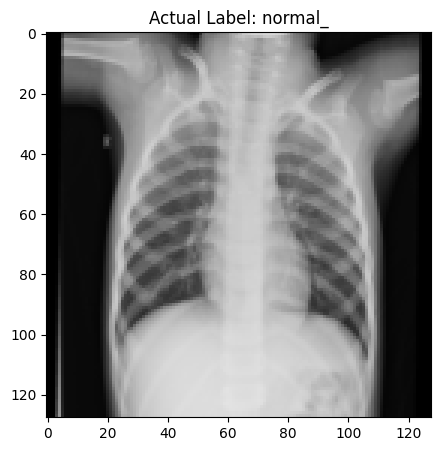

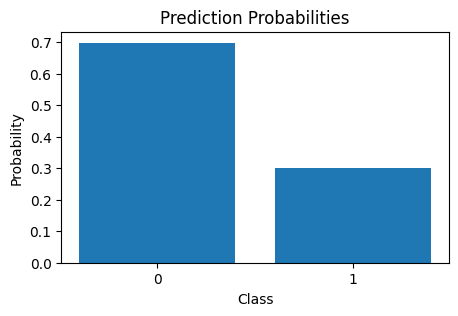

In [ ]:
# 1. Get a batch of images and labels from the DataLoader
img_batch, label_batch = next(iter(test_dataloader_simple))

# 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
img_single, label_single = img_batch[3].unsqueeze(dim=0), label_batch[3]
print(f"Single image shape: {img_single.shape}\n")

# 3. Perform a forward pass on a single image
model_0.eval()
with torch.inference_mode():
    pred = model_0(img_single.to(device))

# 4. Print out the predictions and convert model logits -> pred probs -> pred label
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

# 5. Visualize the image and predictions
image = img_single.squeeze(0).permute(1, 2, 0).numpy()  # Convert the image tensor to a NumPy array

# Plot the image
plt.figure(figsize=(5, 5))
plt.imshow(image, cmap='gray')
plt.title(f"Actual Label: {class_names[label_single]}")

# Create a bar chart for prediction probabilities
pred_probs = torch.softmax(pred, dim=1).squeeze(0).cpu().numpy()
plt.figure(figsize=(5, 3))
plt.bar(range(len(pred_probs)), pred_probs)
plt.xticks(range(len(pred_probs)))
plt.xlabel("Class")
plt.ylabel("Probability")
plt.title("Prediction Probabilities")

# Show the plot
plt.show()


In [ ]:
print("Inference:\nThe histogram for the Prediction Probabilities tell us the probability of our prediction being\nNormal Lung when the actual label is also of a Normal Lung\nHence the model predictions were accurate")

Inference:
The histogram for the Prediction Probabilities tell us the probability of our prediction being
Normal Lung when the actual label is also of a Normal Lung
Hence the model predictions were accurate


In [ ]:
print('We compared the predicted labels and actual labels and our model_0 hence produces good results with a testing accuracy of 86.35%\nAs we can see there is one wrongly predicted label in the above predictions, but we can further increase the accuracy by:\n\t1. Training for more epochs\n\t2. Increasing the number of images in the data\n\t3. Changing the learning rate of our optimizer\n\t4. Changing the optimizer')

We compared the predicted labels and actual labels and our model_0 hence produces good results with a testing accuracy of 86.35%
As we can see there is one wrongly predicted label in the above predictions, but we can further increase the accuracy by:
	1. Training for more epochs
	2. Increasing the number of images in the data
	3. Changing the learning rate of our optimizer
	4. Changing the optimizer


In [ ]:
torch.save(model_0, 'eda_dpl_model.pth') # Saving our model_0